# Creating a Machine Learning Model Based on Smartwatch Accelerometer Data for Predicting Chronological Age

## Objective
The objective of this project is to apply my knowledge and skills on digital biomarkers, machine learning, and data modeling to create my own model and make predictions on my own smartwatch data. This project provides me, Aurel Berger, with an opportunity to demonstrate my understanding of the concepts learned throughout the course "Developing Digital Biomarkers" in the autumn semester 2023 provided by the ETH AI Center. Follow this link to explore the course syllabus [https://im.ethz.ch/education/lectures/digital-biomarkers.html]. **Note that some code snippets were taken directly from the course material prepared by Dr. Filipe Barata, Patrick Langer, and other associated Ph.D. candidates.**

This project aims to develop a machine learning model to predict chronological age using smartwatch accelerometer data. I process accelerometer data, handle missing values, and analyze daily activity patterns. Multiple models, including Random Forest, Linear Regression with Lasso Regularization, and XGBoost, were evaluated. XGBoost emerged as the best performer after nested cross-validation, balancing accuracy and computational efficiency. The final model leverages daily activity rhythms to provide age predictions, demonstrating the potential of wearable data in health monitoring and personalized insights.

## Dataset
2 datasets are required: 1)`exercise5.csv` for model training and evaluation; and 2) my own smartwatch data for my chronological age prediction. All the required code can be found here on my github [https://github.com/auberger/Developing_Digital_Biomarkers/tree/main]. 

1) **`exercise5.csv`** include 6805 rows (6805 participants) and 157 columns. Definition of columns are: 

- `ID`: Participant ID
- `age` (numeric): Age in years
- `gender` (character): "Male" or "Female"
- `bmi` (numeric) : Body mass index (weight in kg^2/height in cm) - you can compute bmi here [https://www.calculator.net/bmi-calculator.html]
- `smoke`(numeric): Current smoke status (1-Yes; 0-No)
- `drink`(numeric): Current drinking status (1-Yes; 0-No)
- `hyper` (numeric): Hypertention status (1-Yes; 0-No).
- `diabetes` (numeric): Diabetes status (1-Yes; 0-No).
- `sleephours` (numeric): Self-reported sleep hours (How much sleep do you usually get at night on weekdays or workdays? Range of values 2-11; 12 indicates more than 12 hours)
- `sleeptouble` (numeric): Sleep trouble status (Ever told doctor had trouble sleeping? or ever told by doctor have sleep disorder? 1-Yes; 0-No).
- `mesor`, `amplitude`, `acrophase`: Pre-calculated coisnor parameters. Mesor and amplitude are expressed in AC (activity counts). 
- `h1`-`h144` (numeric): Hourly mean AC (activity counts) value. `h1` refers to the hourly mean activity count (AC) level between 00:00-00:59 of day 1, `h2` refers to the hourly mean AC between 01:00-01:59 of day 1, and so on. `h144` refers to the hourly mean AC between 23:00-23:59 of day 6. 

2) **My smartwatch data** include 5 colummns: `time`, `Axis1`, `Axis2`, `Axis3`, and `AC`. 


## Table of Content

1. How could this application be used in the real world?
2. Set environment
3. Cosinor Analysis on My Own Data
4. Data Exploration and Preprocessing, and Feature Engineering
5. Model Selection and Training-Evaluation Pipeline Development
6. Making Predictions on My Own Data
7. Discussion of results 

## 1. How could this application be used in the real world?

Today, a biomarker surpassing chronological age for predicting aging rates is currently absent. As we age, the correlation between chronological age and biological age weakens and it gets difficult to directly monitor the aging process rather than its consequences. The proposed model leverages smartwatch accelerometer data and demographic information to predict the user's biological age every week. The primary **output** is the predicted age, potentially accompanied by visualizations of how the user's activity levels align with different age groups. The diverse **multimodal input** data includes smartwatch accelerometer data and contextual numerical and categorical features for robust generalization. The target population spans ages 20 to 80 with different activity levels, potential health conditions, and both genders, focusing on smartwatch users. Therefore, **representative** training and test datasets covering a wide range of ages, genders, and health conditions are essential for the model's generalizability. Stratified splits, especially with respect to age, could be beneficial to ensure that each age group is proportionally represented in both the training and test sets, enhancing the robustness of the model across diverse age demographics.

Imagine a smartwatch assistant not only tracking steps but predicting age based on daily activities. This non-invasive approach provides valuable **insights into the aging process**, supporting **proactive health management** and **personalized recommendations**. Addressing the aging population's health challenges, users can align their lifestyles with predicted age group trends, enhancing informed decision-making and well-being.

Healthcare professionals benefit from insights into the aging process, aiding in **preventive measures** and **personalized interventions**. Insurance companies can leverage predictions to **assess risk factors** that may influence insurance calculations. For researchers, the model offers **valuable insights**, contributing to ongoing studies on aging and related health conditions.

Focusing on the direct benefits for the smartwatch user, the model's effectiveness relies on certain key features: **Explainability:** Model simplicity and insights into relevant features are crucial for trust and interpretability. Users should understand how different behaviors impact the predicted outcome and aging rate, enabling easy implementation of lifestyle changes. **Longitudinal Data:** The consistent wear of smartwatches enables the collection of temporal changes in physiological data over time for a comprehensive understanding of aging. **Precision and Reproducibility:** The model must be precise, reproducible, stable, and applicable in various conditions. A rigorous evaluation strategy is essential, using metrics like RMSE to penalize significant errors and ensure efficacy across diverse age groups (20 to 80). **Autonomy and Scalability:** The smartwatch application promises a scalable, autonomous solution with broad accessibility, enhancing user convenience. **Interpretability:** Avoiding excessive complexity ensures fast operation and interpretability. **Fairness and Privacy:** The model should be unbiased, promote social equity, and prioritize user data privacy. Mechanisms like anonymization and encryption could facilitate this. **Computational Costs:** Given the smartwatch's limited RAM capacities, training, and prediction speed are critical for clinically relevant results and a satisfying user experience. The model should preferably be an eager learner for fast predictions on the smartwatch.

## 2. Set environment

In [2]:
# Basic libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import warnings

# Preprocessing
from CosinorPy import cosinor, cosinor1
import importlib
importlib.reload(cosinor)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
import scipy.stats as sts
from scipy.stats import kstest
from sklearn.decomposition import PCA

# Models and evaluation
from sklearn.linear_model import LinearRegression
from sklearn import metrics, ensemble
from scipy.stats import spearmanr
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso

## 3. Cosinor Analysis on My Own Data

In this section, I present the essential steps for processing sample data. The task involves implementing the necessary code for cosinor analysis using my smartwatch data. Here I chose days 2-7 as an example. You may choose differnet days or lengths. This is sample codes, and please adjust them as needed. 

1. Loading of my smartwatch accelerometer data. Using of **AC (activity count)**. AC is a unit of the accelerometer. This is another unit to express accelerometery data other than MIMS. 
2. Runing 1-component cosinor analysis (cf. exercise 3) and **obtaining cosinor parameters: mesor, amplitude, and acrophase**.
3. Calculating **the hourly mean AC value for 6 days**. Naming them`h1` to `h144` (see column definition above). Examining the data before this step. We may need to consider the missingness of the data. For example, data from the first and the last day of study are typically not included due to partial data. 
4. Combining cosinor parameters and houly AC values. 

In [3]:
# 1. Load the accelerometer data 

myacc = pd.read_csv("counts14_D5k7RpkMsm.csv") 
print('Tab. 1. First 5 observations of the data:')
display(myacc.head())
print(f'The data consists of {myacc.shape[0]} rows and {myacc.shape[1]} columns.') 
print('-'*100)

# 1) Extract date, day, hour, miniute
myacc['time'] = pd.to_datetime(myacc['time'])
myacc['date'] = myacc['time'].dt.date
myacc['day'] = myacc['date'].factorize()[0]+1 
myacc['hour'] = myacc['time'].dt.hour
myacc['minute'] = myacc['time'].dt.minute

# 2) Convert to 0-1439 minutes
myacc['x'] = myacc['hour']*60+myacc['minute']   # Transform 'time' to minute number in a day
print(f'Tab. 2. First 5 observations of the data (with additional columns):')
display(myacc.head())
print(f'The variable "x" indicates the current minute of the day and ranges from {min(myacc["x"])} to {max(myacc["x"])}.')
print('-'*100)

# 3) Exclude data from the first and the last day of study due to incomplete data + take only 6 days (like NHANES data)
# (charging periods got already removed)
myacc = myacc[(myacc['day'] >= 10) &  (myacc['day'] <= 15)] # these days have the least amount of missing hours

# 4) Rename AC as y & add TEST = 001 (temporary id that represents the label used in the Cosinor Model)
myacc = myacc.rename(columns={'AC': 'y'})
myacc['test'] = '001'

# 5) Keep only x, y, test
cosdf = myacc[['x', 'y', 'test']]
print(f'Tab. 3. First 5 observations of the prepared data for the cosinor analysis:')
display(cosdf.head())
print(f'The data for the cosinor analysis consists of {cosdf.shape[0]} rows and {cosdf.shape[1]} columns.')

Tab. 1. First 5 observations of the data:


,time,Axis1,Axis2,Axis3,AC
0,2023-10-10 21:10:00,180,104,157,260.509117
1,2023-10-10 21:11:00,17,62,34,72.725511
2,2023-10-10 21:12:00,14,160,0,160.611332
3,2023-10-10 21:13:00,59,355,196,409.782869
4,2023-10-10 21:14:00,255,472,620,819.883528


The data consists of 19388 rows and 5 columns.
----------------------------------------------------------------------------------------------------
Tab. 2. First 5 observations of the data (with additional columns):


,time,Axis1,Axis2,Axis3,AC,date,day,hour,minute,x
0,2023-10-10 21:10:00,180,104,157,260.509117,2023-10-10,1,21,10,1270
1,2023-10-10 21:11:00,17,62,34,72.725511,2023-10-10,1,21,11,1271
2,2023-10-10 21:12:00,14,160,0,160.611332,2023-10-10,1,21,12,1272
3,2023-10-10 21:13:00,59,355,196,409.782869,2023-10-10,1,21,13,1273
4,2023-10-10 21:14:00,255,472,620,819.883528,2023-10-10,1,21,14,1274


The variable "x" indicates the current minute of the day and ranges from 0 to 1439.
----------------------------------------------------------------------------------------------------
Tab. 3. First 5 observations of the prepared data for the cosinor analysis:


,x,y,test
10810,0,635.683097,001
10811,1,855.005263,001
10812,2,241.598841,001
10813,3,28.284271,001
10814,4,5.000000,001


The data for the cosinor analysis consists of 8158 rows and 3 columns.


In [4]:
# 2. Run 1-component Cosinor analysis -> name your output "cos_results"

# Best fit circadian rhythm parameters ('amplitude', 'acrophase', and 'mesor') from the 1-component model
cos_results = cosinor.fit_group(cosdf, n_components=[1], period=1440, plot=False, plot_phase=False) 

# Keep amplitude, acrophase, mesor.
cos_keep = cos_results[['test', 'mesor', 'amplitude', 'acrophase']]
display(cos_keep)

,test,mesor,amplitude,acrophase
0,001,1047.390196,952.456978,1.880553


In [5]:
# 3. Calculate the hourly mean AC value for 6 days.

# 1) Check # of obs per day per hour - 60 means complete data (1 entry per minute)
print('Tab. 4. Number of observations per day per hour:')
display(pd.crosstab(myacc["day"], myacc["hour"]))
print('-'*100)

# 2) Calculae hourly average AC for available data. 
hrmean = myacc.groupby(['day','hour']).agg(mean=('y', 'mean')).reset_index()
print('Tab. 5. Summary statistics:')
display(hrmean.describe())
print(f'Mean of hourly mean AC: {hrmean["mean"].mean():.1f}')
print(f'Median of hourly mean AC: {hrmean["mean"].median():.1f}')
print(f'AC range of hourly mean AC: [{hrmean["mean"].min():.1f}, {hrmean["mean"].max():.1f}]')
print('-'*100)

# 3) Calculate 'newhour' using conditions to name the columns h1-h144.
hrmean['newhour'] = hrmean.apply(lambda row: row['hour'] + 1 if row['day'] == 10 else (row['day'] - 10) * 24 + row['hour'] + 1, axis=1).astype(int)
hrmean['test'] = "001"
print(f'The final dataframe has {hrmean.shape[0]} rows and a new column "newhour" numerating the hours of 6 days ranging from {hrmean["newhour"].min()} to {hrmean["newhour"].max()}.')

# 4) Do I have 144 rows? If not, why less than 144 rows? Do I have some missing hours?
key = pd.DataFrame({'newhour': range(1, 144)}).astype(int)

# Find missing values
missing = key.merge(hrmean, on='newhour', how='outer')
missing = missing[missing['day'].isna()]
print(f'Tab. 6. {hrmean["newhour"].max() - hrmean.shape[0]} rows are missing due to charging periods of the watch (no data for the entire hour):')
display(missing)

# 5) Now let's pivot wider to make it look like exercise5.csv
hrmean_wide = hrmean.pivot(index = 'test', columns="newhour", values="mean").add_prefix('h').reset_index().rename_axis(None, axis=1)

Tab. 4. Number of observations per day per hour:


hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
10,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,60
11,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,60
12,60,60,60,60,60,60,60,39,0,41,...,60,60,60,60,60,60,60,60,60,60
13,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,60
14,60,60,60,60,60,60,60,60,60,3,...,60,60,60,60,60,60,60,60,60,60
15,60,60,60,60,60,60,60,40,42,60,...,60,60,60,60,29,0,53,60,60,60


----------------------------------------------------------------------------------------------------
Tab. 5. Summary statistics:


,day,hour,mean
count,141.000000,141.000000,141.000000
mean,12.482270,11.468085,1060.368948
std,1.717984,6.985243,1388.493650
min,10.000000,0.000000,0.000000
25%,11.000000,5.000000,116.340534
50%,12.000000,11.000000,591.161193
75%,14.000000,17.000000,1501.718949
max,15.000000,23.000000,9143.353087


Mean of hourly mean AC: 1060.4
Median of hourly mean AC: 591.2
AC range of hourly mean AC: [0.0, 9143.4]
----------------------------------------------------------------------------------------------------
The final dataframe has 141 rows and a new column "newhour" numerating the hours of 6 days ranging from 1 to 144.
Tab. 6. 3 rows are missing due to charging periods of the watch (no data for the entire hour):


,newhour,day,hour,mean,test
56,57,NaN,NaN,NaN,NaN
84,85,NaN,NaN,NaN,NaN
139,140,NaN,NaN,NaN,NaN


In [6]:
# 4. Combine cosinor parameters and hourly data
mydf_final = cos_keep.merge(hrmean_wide, how='inner') # both dataframe has 'test=001' 
mydf_final

,test,mesor,amplitude,acrophase,h1,h2,h3,h4,h5,h6,...,h134,h135,h136,h137,h138,h139,h141,h142,h143,h144
0,001,1047.390196,952.456978,1.880553,858.614585,100.831337,129.62532,78.326612,36.638344,137.516277,...,703.114414,1996.40728,2187.651716,1065.507578,1776.224684,3034.43835,4214.676027,2479.130265,2064.027121,335.394045


## 4. Data Exploration and Preprocessing, and Feature Engineering
1. Loading the dataset (`exercise5.csv`).
2. Selecting and justifying the features we will use for the model. 
3. Engineering of any new features if they will enhance the model's performance.

### Used feature engineering techniques

Given the possibility of correlated features, the ideal number of features might be around 80, which corresponds to the square root of a sample size of approximately 6500. This selection aims to strike a balance between bias and variance in the model.

Firstly, to avoid potential biases, smoking and drinking features were excluded, because these behaviors seem to be more prevalent among younger individuals. This step prevents the model from assuming a lower biological age based on these lifestyle factors.

Furthermore, features exhibiting more than 900 missing values were deliberately discarded to maximize the available observations to improve the model's overall performance with more observations (see big jump in Tab. 7 from index 18 to 19). The remaining missing values were removed by dropping cases or imputing missing acceleration activity counts using Forward or Backward Fill (the mean activity counts of adjacent hours are assumed to be very similar).

In evaluating categorical features, diabetes and hypertension stood out for the substantial differences in age among their classes, justifying their relevance (see Fig. 10, 12, and results of Wilcoxon signed-rank test). Aiming for a multimodal approach, other categorical variables were preserved as well for their potential contribution to complex interactions. Certain categorical features, such as diabetes, exhibit significant class imbalance (see Fig. 7, 9, 11). Therefore, it is essential to be cautious and ensure that the prevalence or distribution of our target population, for which predictions are intended, is relatively similar.

To address the challenge of dimensionality and potential overfitting, Principal Component Analysis (PCA) was applied to hourly accelerometer data (h1-h144). The use of standardization before PCA is crucial to ensure that each feature contributes proportionally to the analysis, preventing variables with larger scales from dominating the principal components. PCA retained most information and had no discernible impact on model performance, but could decrease computational costs. The accelerometer features were effectively reduced from 144 to 94.

Lastly, Lasso, inherently an embedded method, was employed as a filter method before training the algorithms. However, only linear regression demonstrated a noticeable benefit from it. Consequently, the 63 features selected by Lasso were exclusively reserved for optimizing the Linear Regression algorithm. 

**Handling missing values:**

In [7]:
def compute_missing_values(data, axis=0, objective='variable'):
    """
    Calculate and present information about missing values in a DataFrame.

    Parameters:
    - data (DataFrame): The input DataFrame.
    - axis (int, optional): The axis along which to count missing values. Default is 0 (columns).
    - objective (str, optional): The type of entity with missing values (e.g., 'variable' or 'sample'). Default is 'variable'.

    Returns:
    - df_info_dat (DataFrame): Information about missing values, including counts and names of variables or samples.
    """
    
    # Calculate the number of missing values for each variable or sample
    missing = data.isna().sum(axis=axis)
    missing = missing.sort_values(ascending=False)
    
    # Initialize dictionaries to store information about missing values
    info_dat = {}
    copy = {}
    pd.set_option('display.max_rows', None)
    
    # Iterate over unique counts of missing values
    for i in missing.unique():
        # Extract variables or samples with the current count of missing values
        variables = missing.loc[missing == i].index.values[:]
        copy[i] = variables
        variables = variables[:6].astype(str)  # Display at most 6 names
        info_dat[i] = ", ".join(variables)
    
    # Create DataFrames to present information
    df_info_dat = pd.DataFrame(info_dat.items(), columns=[f'Number of missing values (per {objective})', f'{objective}s (max. 6 are displayed)'])
    df_copy = pd.DataFrame(copy.items(), columns=[f'Number of missing values (per {objective})', f'{objective}s (max. 6 are displayed)'])
    
    # Initialize a new column to store the count of variables or samples
    df_info_dat[f'Number of {objective}s'] = 0
    
    # Count the number of variables or samples for each count of missing values
    for j in range(0, len(df_copy[f'{objective}s (max. 6 are displayed)'])):
        df_info_dat.loc[j, f'Number of {objective}s'] = len(df_copy.loc[j, f'{objective}s (max. 6 are displayed)'])
    
    return df_info_dat

In [8]:
# Load the data
dat = pd.read_csv("exercise5.csv", index_col = 0) 

# Convert string values to numeric 
le = LabelEncoder()
dat['gender'] = le.fit_transform(dat['gender']) #0-female; 1-male

# Change data types if necessary
dat = dat.astype({
    'gender': 'category',
    'smoke': 'category',
    'drink': 'category',
    'hyper': 'category',
    'diabetes': 'category',
    'sleeptrouble': 'category'
})

# Missing values per variable and sample  
print('Tab. 7. Missing values per variable:')
display(compute_missing_values(dat, axis=0, objective='variable'))  # Identify variables with most missing values
print('-'*100)
print('Tab. 8. Missing values per observation:')
display(compute_missing_values(dat, axis=1, objective='sample'))    # Identify samples with most missing values

# Drop variables with > 900 missing values (look at big jump in first dataframe from index 18 to 19)
cols_before = dat.shape[1]
dat = dat.dropna(axis=1, thresh=5905)    # we keep all columns with more than 5905 specified values (we drop all columns with more than 900 (=6805-5905) NA values)
cols_after = dat.shape[1]

# Drop samples with > 24 missing values (look at big jump in second dataframe from index 19 to 20)
rows_before = dat.shape[0]
dat = dat.dropna(axis=0, thresh=109)    # we keep all rows with more than 109 specified values (we drop all columns with more than 24 (=133-109) NA values)
rows_after = dat.shape[0]

Tab. 7. Missing values per variable:


,Number of missing values (per variable),variables (max. 6 are displayed),Number of variables
0,970,h125,1
1,968,h126,1
2,962,"h124, h127",2
3,961,h132,1
4,960,h133,1
5,959,h131,1
6,958,h134,1
7,956,h128,1
8,955,h129,1
9,954,h130,1


----------------------------------------------------------------------------------------------------
Tab. 8. Missing values per observation:


,Number of missing values (per sample),samples (max. 6 are displayed),Number of samples
0,72,"1273, 5128, 1874, 5379, 5343, 320",87
1,61,5863,1
2,58,"515, 6026, 5355, 3837",4
3,57,4178,1
4,55,"2065, 3106",2
5,54,"1925, 1509, 2448, 379",4
6,53,"5111, 1896",2
7,52,"3306, 4211, 3902, 2792, 249, 1416",8
8,51,"3237, 1028, 6568, 5017, 6550, 599",6
9,50,"1562, 5368, 402",3


In [9]:
pd.set_option('display.max_rows', 10)  # set option back to only display 10 rows
print(f'We dropped {cols_before-cols_after} hourly mean AC (activity counts) features.')
print(f'We dropped {rows_before-rows_after} participants.')

# Store remaining numerical and categorical columns (of features)
num_columns = dat._get_numeric_data().columns
cat_columns = list(set(dat.columns)-set(num_columns))

# Imputing missing values with Forward Fill and Backward Fill (especially for h1 column)
# The mean activity counts of adjacent hours is assumed to be very similar
missing_before = dat.isna().sum().sum()
dat.iloc[:, 14:] = dat.iloc[:, 14:].fillna(method='ffill', axis=0)
dat.iloc[:, 13:] = dat.iloc[:, 13:].fillna(method='bfill', axis=0)
missing_after = dat.isna().sum().sum()
print(f'For the hourly mean AC values we imputed {missing_before-missing_after} missing values ({(missing_before-missing_after)/(dat.shape[0]*dat.shape[1])*100:.2f}% of the data) by using values from adjacent hours.')

# Fill last missing values with the most frequent value for categorical columns and median for numerical columns
for column in dat.columns:
    if column in cat_columns:
        most_frequent = dat[column].mode().iloc[0]
        dat[column].fillna(most_frequent, inplace=True)
    else:
        median_value = dat[column].median()
        dat[column].fillna(median_value, inplace=True)
    
print(f'For the last {missing_after} missing values ({(missing_after)/(dat.shape[0]*dat.shape[1])*100:.2f}% of the data) we simply replace the missing value by the most frequent value in that column.')

We dropped 24 hourly mean AC (activity counts) features.
We dropped 268 participants.
For the hourly mean AC values we imputed 8821 missing values (1.01% of the data) by using values from adjacent hours.
For the last 76 missing values (0.01% of the data) we simply replace the missing value by the most frequent value in that column.


**Data Exploration (and Feature Selection):**

Tab. 9. NHANES dataset:


,ID,age,gender,bmi,smoke,drink,hyper,diabetes,sleephours,sleeptrouble,...,h111,h112,h113,h114,h115,h116,h117,h118,h119,h120
1,1,22,1,23.3,0,0,0,0,8.0,0,...,2187.440058,3093.381944,1485.109224,564.330192,677.842620,1478.970810,760.380525,817.596553,25.411269,221.378903
2,2,44,0,23.2,0,0,0,0,8.0,1,...,1029.997086,3526.993064,380.058682,1171.026322,1448.004316,1452.942926,1798.443000,661.496155,1013.766748,65.514514
3,3,21,1,20.1,0,1,0,0,8.0,0,...,1091.997076,1302.560345,1678.718391,3189.240286,1835.235380,774.333337,990.216374,894.502778,1956.869700,1857.798251
4,4,80,1,33.9,0,1,1,0,9.0,0,...,1604.268678,1587.602342,2426.100000,1452.299435,175.982262,1052.342427,642.339080,990.347222,1803.629167,1473.207626
5,5,51,1,20.1,1,0,1,0,8.0,0,...,1353.409613,1426.378545,1739.853454,2791.020836,766.082011,746.706112,2978.691667,950.344650,1803.759100,2486.381611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6801,6801,61,1,30.0,0,1,1,0,7.0,0,...,40.833420,116.400058,1385.947368,3139.511299,2805.801389,3199.184722,2920.296610,2861.722222,3226.801389,3189.616071
6802,6802,34,1,23.7,0,0,0,0,5.0,1,...,3115.063889,2697.819444,2313.441667,2772.556497,2310.633648,1924.723684,1060.420980,548.735125,638.317010,159.176690
6803,6803,80,0,21.3,0,0,1,0,8.0,0,...,3513.602778,4005.218056,3161.986111,4356.062500,3439.486111,1999.813725,2102.355556,1601.453398,2172.261016,768.399523
6804,6804,80,1,24.9,0,1,1,0,9.0,1,...,2415.158333,2108.121477,1413.068482,2199.552803,1380.191830,2389.630556,1405.370701,1710.168158,49.491208,61.163848


----------------------------------------------------------------------------------------------------

Tab. 10. Summary statistics of most relevant numerical variables of NHANES dataset:


,age,bmi,sleephours,mesor,amplitude,acrophase
count,6537.000000,6537.000000,6537.000000,6537.000000,6537.000000,6537.000000
mean,51.231758,29.023436,6.896589,1017.365003,988.484728,2.452816
std,17.934277,6.889722,1.419186,305.198597,364.272656,0.533534
min,20.000000,14.100000,2.000000,40.374492,32.527906,0.012689
25%,36.000000,24.300000,6.000000,811.770873,734.384145,2.175229
50%,51.000000,27.900000,7.000000,1011.000639,970.870082,2.482003
75%,66.000000,32.300000,8.000000,1221.863025,1222.730976,2.755048
max,80.000000,82.900000,12.000000,2244.939745,2615.154377,6.266513


----------------------------------------------------------------------------------------------------


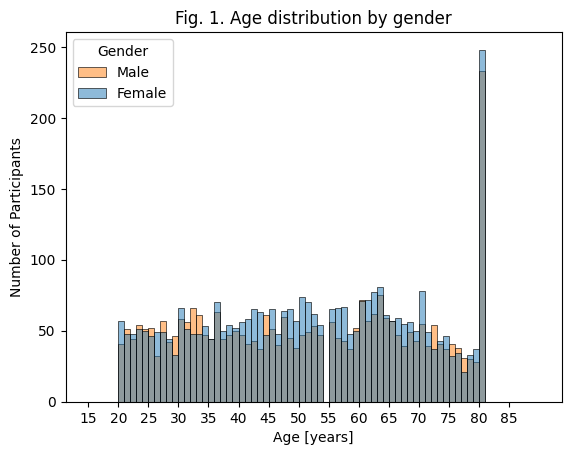

----------------------------------------------------------------------------------------------------
Testing numerical variables for normality:

Using the Kolmogorov–Smirnov test with sign. level 0.000391, it can be assumed that there are in total 0 normally and 126 non-normally distributed variables.
The Age of participants seems to be also not normally distributed.
----------------------------------------------------------------------------------------------------
Test if age is significantly different among variable groups using the Wilcoxon signed rank test (sign. level = 0.0071428571428571435):

Significant difference of the age among diabetes-groups (p-value = 2.5478919503136053e-105).
Significant difference of the age among drink-groups (p-value = 9.291854966383025e-07).
Significant difference of the age among hyper-groups (p-value = 0.0).
Significant difference of the age among smoke-groups (p-value = 4.596051092711372e-28).
No significant difference of the age among gender-gro

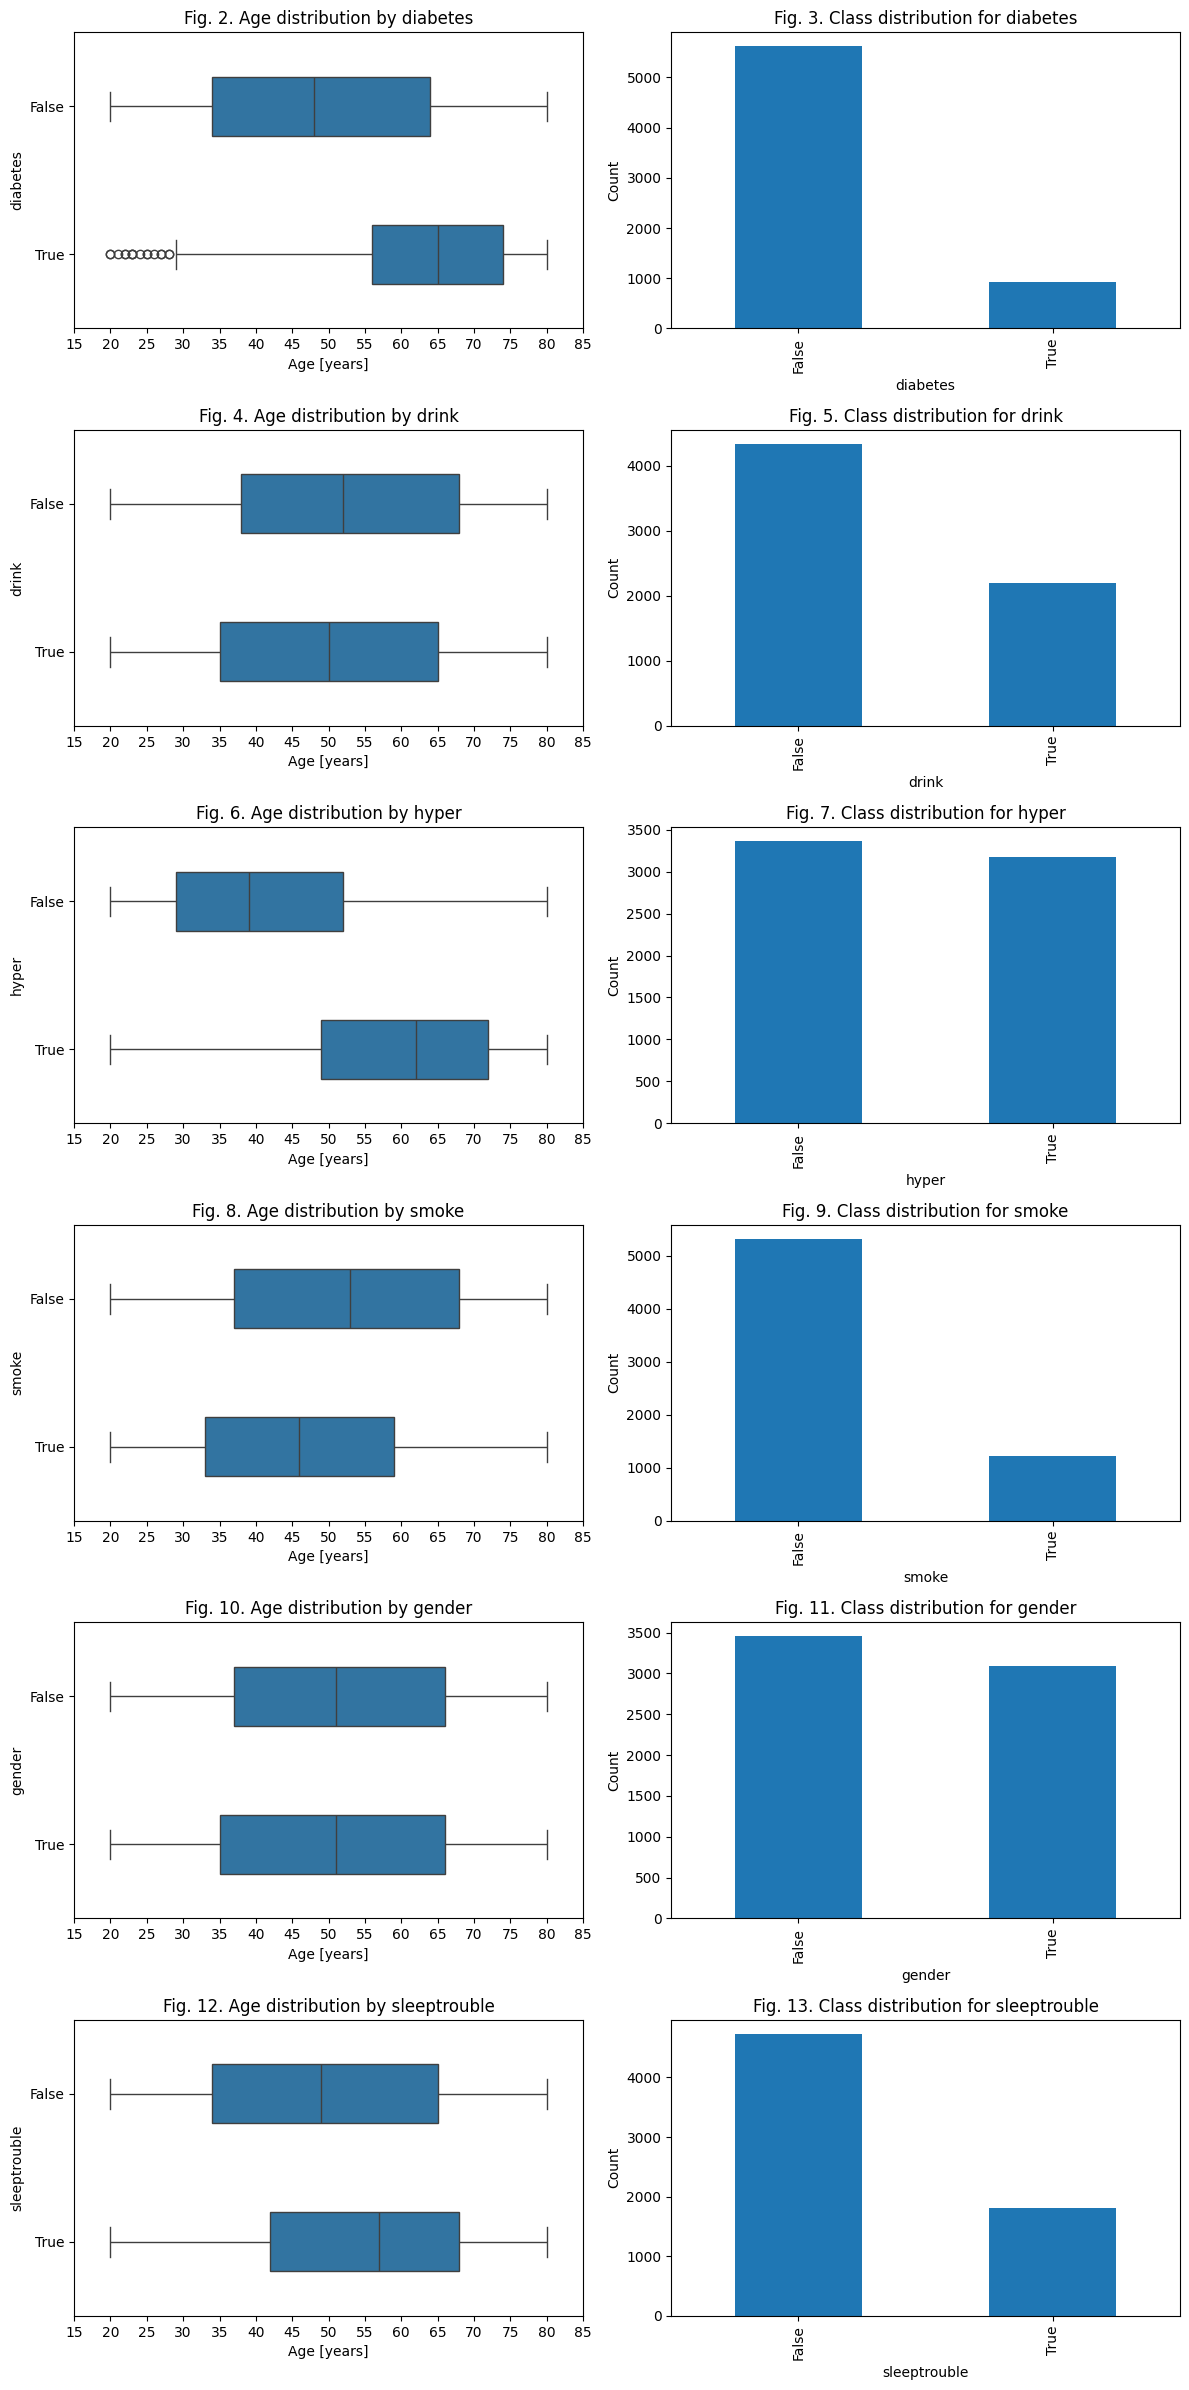

In [10]:
# Inspect data
print('Tab. 9. NHANES dataset:')
display(dat)

# 1. Numerical variables
print('-'*100)
print('\nTab. 10. Summary statistics of most relevant numerical variables of NHANES dataset:')
display(dat.describe()[['age', 'bmi', 'sleephours', 'mesor', 'amplitude', 'acrophase']])
print('-'*100)

# 1) Plot the age distribution separated by gender
age = sns.histplot(dat, x='age', binwidth=1, binrange=(15, 90), hue='gender')
age.set(xticks=np.arange(15, 90, 5), xlabel='Age [years]', ylabel='Number of Participants', title='Fig. 1. Age distribution by gender')
age.legend(title='Gender', loc='upper left', labels=['Male', 'Female'])
plt.show()

# 2) Testing all numerical variables for normality
normal = {}
nonnormal = {}
alpha = 0.05/(len(num_columns)+1)   # take multiple testing into account

for var in num_columns:
    pvalue = kstest(dat[var], 'norm').pvalue  # I use the Kolmogorov–Smirnov test instead of Shapiro-Wilk test because of the huge sample size
    # If the p-value is less than the significance level, we consider the variable as not normally distributed
    if pvalue < alpha:
        nonnormal[var] = pvalue
    else:
        normal[var] = pvalue

normal_var = normal.keys()
nonnormal_var = nonnormal.keys()

print('-'*100)
print('Testing numerical variables for normality:\n')
print(f"Using the Kolmogorov–Smirnov test with sign. level {alpha:.6f}, it can be assumed that there are in total {len(normal_var)} normally and {len(nonnormal_var)-1} non-normally distributed variables.")
print("The Age of participants seems to be also not normally distributed.")

# 2. Categorical variables (effect on age)
fig, axes = plt.subplots(len(cat_columns), 2, figsize=(12, 4 * len(cat_columns)))

# 1) Plot the age distribution separated by a specific categorical variable
alpha = 0.05/(len(cat_columns)+1)   # take multiple testing into account
print('-'*100)
print(f'Test if age is significantly different among variable groups using the Wilcoxon signed rank test (sign. level = {alpha}):\n')

for i, variable in enumerate(cat_columns):
    # Boxplots to compare variable groups
    plot = sns.boxplot(data=dat, x='age', y=variable, ax=axes[i, 0], width=0.4)
    axes[i, 0].set(xticks=np.arange(15, 90, 5), xlabel='Age [years]', ylabel=variable, title=f'Fig. {2*(i+1)}. Age distribution by {variable}')
    axes[i, 0].set_yticks(range(2))
    axes[i, 0].set_yticklabels(['False','True'])

    # Test if age is significantly different between variable groups (Wilcoxon because age is clearly not normally distributed)
    pvalue = sts.ranksums(dat.loc[dat[variable] == 1]['age'], dat.loc[dat[variable] == 0]['age']).pvalue
    # If the p-value is less than the significance level, we consider the age of the 2 different variable groups significantly different
    if pvalue < alpha:
        print(f"Significant difference of the age among {variable}-groups (p-value = {pvalue}).")
    else:
        print(f"No significant difference of the age among {variable}-groups (p-value = {pvalue}).")

    # Bar plot of class distribution
    dat[variable].value_counts().plot(kind='bar', ax=axes[i, 1])
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].set_xlabel(variable)
    axes[i, 1].set_title(f'Fig. {2*(i+1)+1}. Class distribution for {variable}')
    axes[i, 1].set_xticklabels(['False','True'])

# Adjust layout
plt.tight_layout()

# 2) Drop smoke and drink (we don't want our model to assume that smokers and drinkers have a lower biological age)
# It's just a trend that younger people tend to smoke and drink more
dat = dat.drop(['smoke', 'drink'], axis=1)

**Further Preprocessing:**

In [11]:
# NOTE: Feature Selection should be carried out using the training set only to avoid data leakage!

# set feature and target variables (drop ID) 
X = dat.iloc[:, 2:]
y = dat.iloc[:, 1]

# Split the data into training and test datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

**Dimensionality reduction with PCA:**

Number of principal components needed to explain 95% of the variance in the data: 94 (out of 120)


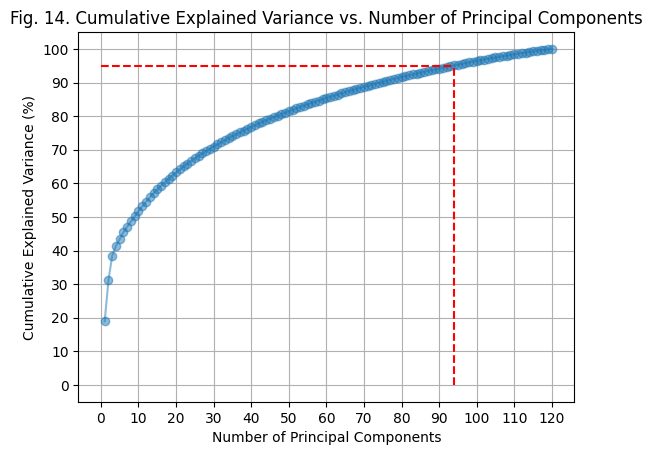

In [12]:
# Extract hourly mean AC columns
hourly_columns = X_train._get_numeric_data().columns[5:]
hourly_training_data = X_train[hourly_columns]
hourly_test_data = X_test[hourly_columns]

# Standardize the data (PCA is sensitive to the scale of the input features)
scaler = StandardScaler()
hourly_training_data_scaled = scaler.fit_transform(hourly_training_data)
hourly_test_data_scaled = scaler.transform(hourly_test_data)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(hourly_training_data_scaled)
pca_test = pca.transform(hourly_test_data_scaled)  # Transform the test set using the trained PCA

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of principal components needed to explain 95% of the variation
n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of principal components needed to explain 95% of the variance in the data: {n_components_95} (out of {len(hourly_columns)})")

# Plot the explained variance in percent
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance * 100, marker='o', alpha=0.5)
plt.xticks(np.arange(0,125,10))
plt.yticks(np.arange(0,105,10))
plt.hlines(y=95, xmin=0, xmax=n_components_95, colors='r', linestyle='--')
plt.vlines(x=n_components_95, ymin=0, ymax=95, colors='r', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Fig. 14. Cumulative Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Select the first n_components_95 principal components
X_train_selected = pca_result[:, :n_components_95]
X_test_selected = pca_test[:, :n_components_95]  

# Create column names for the selected principal components
pc_columns = [f'AC_PC{i+1}' for i in range(n_components_95)]

# Create DataFrames for the selected principal components
X_train_pc = pd.DataFrame(data=X_train_selected, columns=pc_columns)
X_test_pc = pd.DataFrame(data=X_test_selected, columns=pc_columns)

# Concatenate PC dataframe with first 9 columns (other features) of X_train
X_train_combined = pd.concat([X_train[X_train.columns[:9]].reset_index(drop=True), X_train_pc.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_test[X_train.columns[:9]].reset_index(drop=True), X_test_pc.reset_index(drop=True)], axis=1)

**Feature Selection with lasso regression:**

In [13]:
# Create a Lasso regression model
lasso_model = Lasso(alpha=0.1)  # You can adjust the alpha parameter for the level of regularization

# Fit the model on the training data
lasso_model.fit(X_train_combined, y_train)

# Get the selected features (non-zero coefficients)
selected_features = np.where(lasso_model.coef_ != 0)[0]
X_train_final = X_train_combined.iloc[:,selected_features]
X_test_final = X_test_combined.iloc[:,selected_features]

# Selected features
print(f'Selected features with Lasso regression ({len(selected_features)} out of {X_train_combined.shape[1]}): \n{X_train_final.columns.values}')
print(f'\nDropped features ({X_train_combined.shape[1] - len(selected_features)} out of {X_train_combined.shape[1]}): \n\
{X_train_combined.drop(columns = X_train_combined.columns[selected_features]).columns.values}')

# Display the resulting DataFrames
print('-'*100)

print("\nTab. 11. Training Set with Principal Components and selected features with Lasso Regression:")
display(X_train_final)

print("\nTab. 12. Test Set with Principal Components and selected features with Lasso Regression:")
display(X_test_final)

Selected features with Lasso regression (63 out of 103): 
['gender' 'bmi' 'hyper' 'diabetes' 'sleephours' 'sleeptrouble' 'mesor'
 'amplitude' 'acrophase' 'AC_PC1' 'AC_PC2' 'AC_PC3' 'AC_PC4' 'AC_PC5'
 'AC_PC6' 'AC_PC7' 'AC_PC8' 'AC_PC9' 'AC_PC10' 'AC_PC12' 'AC_PC14'
 'AC_PC16' 'AC_PC17' 'AC_PC18' 'AC_PC19' 'AC_PC20' 'AC_PC21' 'AC_PC22'
 'AC_PC23' 'AC_PC25' 'AC_PC26' 'AC_PC27' 'AC_PC28' 'AC_PC30' 'AC_PC32'
 'AC_PC33' 'AC_PC34' 'AC_PC35' 'AC_PC37' 'AC_PC38' 'AC_PC39' 'AC_PC44'
 'AC_PC47' 'AC_PC48' 'AC_PC49' 'AC_PC51' 'AC_PC53' 'AC_PC55' 'AC_PC60'
 'AC_PC61' 'AC_PC64' 'AC_PC67' 'AC_PC70' 'AC_PC75' 'AC_PC76' 'AC_PC78'
 'AC_PC80' 'AC_PC81' 'AC_PC86' 'AC_PC87' 'AC_PC88' 'AC_PC89' 'AC_PC94']

Dropped features (40 out of 103): 
['AC_PC11' 'AC_PC13' 'AC_PC15' 'AC_PC24' 'AC_PC29' 'AC_PC31' 'AC_PC36'
 'AC_PC40' 'AC_PC41' 'AC_PC42' 'AC_PC43' 'AC_PC45' 'AC_PC46' 'AC_PC50'
 'AC_PC52' 'AC_PC54' 'AC_PC56' 'AC_PC57' 'AC_PC58' 'AC_PC59' 'AC_PC62'
 'AC_PC63' 'AC_PC65' 'AC_PC66' 'AC_PC68' 'AC_PC69' 'AC_PC7

,gender,bmi,hyper,diabetes,sleephours,sleeptrouble,mesor,amplitude,acrophase,AC_PC1,...,AC_PC75,AC_PC76,AC_PC78,AC_PC80,AC_PC81,AC_PC86,AC_PC87,AC_PC88,AC_PC89,AC_PC94
0,0,27.3,1,1,7.0,0,1290.017179,1005.372529,3.222370,1.678983,...,0.097338,-0.259676,0.267521,0.091864,0.086539,0.029717,-0.172515,0.432317,0.105857,0.137297
1,1,21.9,0,0,7.0,0,1064.027121,1329.797340,2.304875,1.990232,...,1.102166,0.534773,-0.385663,-0.406856,-0.348446,0.091078,-0.378604,-0.045573,-0.646910,0.333851
2,1,30.8,1,0,9.0,0,769.675167,494.004867,0.294608,-7.378810,...,0.998090,0.053187,0.445199,-0.144764,0.141286,-0.722933,-0.044335,0.388388,0.017563,-0.485735
3,0,24.5,1,0,8.0,1,959.346834,852.627382,2.337599,-0.716681,...,-0.525239,-0.331890,0.956593,0.655056,-0.042382,0.986687,-0.162357,-0.842882,0.489465,-0.357285
4,0,20.3,0,0,8.0,0,1413.494191,1496.022857,2.402968,7.256746,...,-0.427567,-0.973656,0.276291,0.854073,-1.964201,0.266554,0.436812,0.040760,-0.395684,1.882557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5224,1,28.9,0,0,7.0,0,985.596852,897.413250,2.656673,0.517721,...,-0.305559,-0.836482,-0.355938,0.112920,0.402404,-0.276102,0.089691,-0.210576,0.284255,0.561045
5225,0,24.6,0,0,6.0,0,936.279025,573.198363,2.427805,-1.380306,...,-0.492267,0.555648,-0.662157,0.405466,-0.737494,-0.131923,0.345251,-1.131678,-1.141146,-0.854860
5226,1,39.8,1,0,6.0,1,753.709663,549.523987,2.538243,-4.206097,...,0.312878,-0.693366,-0.592052,0.372895,0.452229,-0.578417,-0.566255,-0.274727,-0.115209,0.915114
5227,0,34.8,1,0,7.0,0,1180.642848,947.315130,2.346671,2.021098,...,0.585283,-0.012497,0.144064,-0.117101,-0.089466,0.351375,-0.311651,0.049192,-0.232501,-0.792943



Tab. 12. Test Set with Principal Components and selected features with Lasso Regression:


,gender,bmi,hyper,diabetes,sleephours,sleeptrouble,mesor,amplitude,acrophase,AC_PC1,...,AC_PC75,AC_PC76,AC_PC78,AC_PC80,AC_PC81,AC_PC86,AC_PC87,AC_PC88,AC_PC89,AC_PC94
0,0,33.6,1,0,8.0,0,767.912738,981.093813,2.297586,-2.473034,...,-1.208384,0.044309,0.453082,0.255260,0.692170,0.255544,-0.866389,0.394545,0.833109,0.240992
1,1,29.1,0,0,6.0,0,1294.461916,1423.841260,2.021860,4.207461,...,-1.433809,-0.614797,-1.215163,0.048440,1.027451,0.875016,-0.166033,-0.677942,-0.216891,0.489161
2,1,28.7,0,1,8.0,0,1307.726041,1138.211056,2.886157,2.997521,...,-0.080887,-1.427503,0.167971,0.537141,1.663328,0.511093,-0.520229,-0.029747,-0.255784,-0.168286
3,0,35.5,1,1,5.0,1,718.485862,648.656927,2.602261,-4.714438,...,-0.242236,0.318170,0.426644,-0.617616,-1.097616,-0.263194,-0.753611,-0.463118,-0.033513,-0.045509
4,0,22.0,1,0,5.0,0,1224.764378,480.093838,2.631354,1.054772,...,0.941185,0.883853,0.553605,-0.639199,-1.888709,0.257141,-1.606015,-1.049063,0.892190,-0.882585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,1,28.4,0,0,9.0,0,358.860860,420.416026,2.567520,-9.779978,...,0.164547,0.652833,-0.158809,0.040763,-0.648815,0.626619,0.390634,0.356703,0.358481,0.278213
1304,1,27.1,0,0,6.0,0,1183.980715,1188.405420,2.166496,3.010861,...,0.041228,-0.290790,0.329796,-0.546085,-0.254136,0.373493,0.714779,0.343069,0.323186,-0.194057
1305,1,25.8,1,0,8.0,0,1353.101709,1465.703939,2.761338,5.313528,...,-0.046732,0.384340,0.332135,-1.041147,-0.060710,0.009543,1.015719,1.102279,0.651316,-0.645515
1306,0,31.3,1,1,6.0,0,741.888444,843.763468,3.004632,-3.353032,...,-0.817147,0.189661,1.307191,0.060145,0.291325,-1.344162,0.419502,-0.438869,-0.593586,-0.442036


## 5. Model Selection and Training-Evaluation Pipeline Development
1. Selecting of 3 machine learning algorithms for the task. 
2. Creating a training and evaluation pipeline. 

### Reasoning of the evaluation choice, the model architecture, and its  hyperparameters.

I have selected two evaluation metrics, RMSE and MAE, to guide my decision-making process. Primarily, I based my choices regarding features, hyperparameters, and design on the RMSE metric. To provide a comprehensive assessment and ensure a more robust evaluation, I also incorporated MAE as a secondary metric with more robustness to large errors. The comparison of all algorithms demonstrated similar performance, with the two metrics generally aligning. 

The strong agreement between the two metrics is logical when we analyze the distribution of residuals across all five validation folds, as illustrated in Fig. 16. In this representation, the error distribution appears remarkably consistent across all three algorithms. An algorithm with more extreme outliers would disproportionately impact its RMSE. 

Beyond traditional evaluation metrics, I examined feature importance, considering the need for an explainable and interpretable yet multimodal model. For XGBoost, the much more uniform distribution of feature importance across features distinguishes it from the other algorithms, as highlighted in Fig. 17-19. This reduces its dependence on specific features and increases robustness to noise. In contrast, Random Forest heavily relies on the hypertension feature, constituting over 30% of the model's output. Furthermore, XGBoost demonstrates a greater dependence on accelerometer data compared to the other algorithms. However, we have to be careful with a multimodal approach to avoid too high complexity and ensure enough data to prevent overfitting.

### Reasoning of the model training and evaluation strategy.
1. Training of the models on the training data and comparing the model performance. 
2. Selecting the best model and evaluate on the testing data using appropriate evaluation metrics.

In adherence to the no free lunch theorem, I employed a diverse set of algorithms, including a linear regressor, an ensemble bagging method, and a boosting algorithm. For model selection, a nested cross-validation was used according to the picture below. Hyperparameter tuning was performed in the inner loop with a 2-fold cross-validation using GridSearch. This process was repeated across all 5 folds of the outer loop, generating five evaluation scores, each corresponding to the best hyperparameter settings determined in the inner loop.

Concerning hyperparameter grid selection, a regularization hyperparameter with a substantial alpha value (around 20) was incorporated into the linear regression model to penalize overly complex models.

For the random forest algorithm, hyperparameter tuning involved adjusting the number of trees in the forest and the maximum number of levels in each decision tree. While consistent performance improvements were observed with increased hyperparameters, I decided to stop the optimization to avoid excessive computational costs.

In the case of XGBoost, an optimized model with 20 decision trees for boosting and a maximum tree depth of 3 resulted in the best outcomes.

I iteratively adjusted the hyperparameter grids to ensure the best parameters were located within the middle of the grid. While more hyperparameters could have been explored, such as the maximum number of features considered for node splitting in random forest or learning rates and gamma for XGBoost, I tried to keep a balance to maintain computational efficiency.

After selecting XGBoost as the final model, I conducted an additional grid search on the entire training dataset with 5-fold cross-validation to assess hyperparameter stability. Fortunately, the selected hyperparameter setting demonstrated consistency when compared to the earlier findings on the validation set.

![Nested Cross-Validation](nested-cv-image.png)

Image source: Sebastian Raschka, STAT 451 - Introduction to Machine Learning and Statistical Pattern Classification

**Algorithm Comparison using Nested Cross-Validation:**

In [14]:
# Define functions to calculate RMSE and MAE
def calculate_metrics(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) between true and predicted values.

    Parameters:
    - y_true (array-like): The true values.
    - y_pred (array-like): The predicted values.

    Returns:
    - rmse (float): Root Mean Squared Error.
    - mae (float): Mean Absolute Error.
    """
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

In [15]:
# Selection of regression models
model_names = ['Ridge Regression', 'Random Forest', 'XGBoost']
models = []
models.append(Ridge())
models.append(ensemble.RandomForestRegressor(random_state=123, n_jobs=-1))
models.append(XGBRegressor(random_state=123, n_jobs=-1))
best_models = []  # to save best estimators

# List to store all residuals
all_residuals_train = []
all_residuals_val = []

# Setting up the parameter grids
param_grids = []

param_LR = [{'alpha': [14, 16, 18, 20, 22, 24, 26, 28]}]  # 8 possibilities
param_RF = [{'n_estimators': [50, 100, 150], 'max_depth': [6, 7, 8]}] # 9 possibilities
param_xgboost = [{'n_estimators': [20, 40, 60], 'max_depth': [1, 2, 3]}] # 9 possibilities

param_grids.append(param_LR)
param_grids.append(param_RF)
param_grids.append(param_xgboost)

# Iterate over the 3 regression models (Nested Cross-validation for every algorithm)
for i in range(len(models)):  
    # Select current model
    model_name = model_names[i]
    model = models[i]
    param_grid = param_grids[i]

    # List to store residuals of an algorithm
    residuals_train = []
    residuals_val = []
    
    # Use selected features with Lasso regression only for linear regression (others are affected negatively):
    if model_name == 'Ridge Regression':
        X_train_final = X_train_final.apply(pd.to_numeric) # Make sure that all values are numeric (instead of categorical dtype)
        X_test_final = X_test_final.apply(pd.to_numeric)
    else:
        X_train_final = X_train_combined.apply(pd.to_numeric)
        X_test_final = X_test_combined.apply(pd.to_numeric)
        
    print(100 * '-', '\n')
    print(f'Tab. {13+i}.\n')
    print('Algorithm:', model_name)
    print('    Inner loop:')

    # Perform 10-fold cross-validation and calculate evaluation metrics for training and validation set
    outer_rmse_scores = []
    outer_mae_scores = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    fold = 1

    for train_idx, valid_idx in outer_cv.split(X_train_final, y_train):
        inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=123)
        gcv = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=inner_cv, refit=True)
        gcv.fit(X_train_final.iloc[train_idx], y_train.iloc[train_idx]) # run inner loop hyperparam tuning
        
        # Save best model of each fold for later feature importance analysis
        best_models.append(gcv.best_estimator_)
    
        # Performance on inner validation folds
        print(f'\n        RMSE (avg. of inner validation folds): {np.sqrt(-1 * gcv.best_score_):.2f}')
        print('        Best parameters:', gcv.best_params_)
        
        # Performance on outer test folds 
        y_pred = gcv.best_estimator_.predict(X_train_final.iloc[valid_idx])
        rmse, mae = calculate_metrics(y_train.iloc[valid_idx], y_pred)
        outer_rmse_scores.append(rmse)
        outer_mae_scores.append(mae)
        
        print(f'        RMSE (on outer test fold {fold}): {rmse:.2f}')
        print(f'        MAE (on outer test fold {fold}): {mae:.2f}')

        # Calculate and store residuals
        y_pred_train = gcv.best_estimator_.predict(X_train_final.iloc[train_idx])
        
        residuals_train.extend(y_train.iloc[train_idx] - y_pred_train)
        residuals_val.extend(y_train.iloc[valid_idx] - y_pred)
        
        fold += 1

    all_residuals_train.append(residuals_train)
    all_residuals_val.append(residuals_val)
    
    print('\n    Outer Loop:')
    print(f'\n        RMSE: {np.mean(outer_rmse_scores):.2f} +/- {2 * np.std(outer_rmse_scores):.2f}')
    print(f'        MAE: {np.mean(outer_mae_scores):.2f} +/- {2 * np.std(outer_mae_scores):.2f}')

---------------------------------------------------------------------------------------------------- 

Tab. 13.

Algorithm: Ridge Regression
    Inner loop:

        RMSE (avg. of inner validation folds): 13.70
        Best parameters: {'alpha': 24}
        RMSE (on outer test fold 1): 13.50
        MAE (on outer test fold 1): 10.81

        RMSE (avg. of inner validation folds): 13.61
        Best parameters: {'alpha': 20}
        RMSE (on outer test fold 2): 13.76
        MAE (on outer test fold 2): 11.23

        RMSE (avg. of inner validation folds): 13.66
        Best parameters: {'alpha': 20}
        RMSE (on outer test fold 3): 13.59
        MAE (on outer test fold 3): 10.96

        RMSE (avg. of inner validation folds): 13.68
        Best parameters: {'alpha': 28}
        RMSE (on outer test fold 4): 13.89
        MAE (on outer test fold 4): 11.38

        RMSE (avg. of inner validation folds): 13.80
        Best parameters: {'alpha': 18}
        RMSE (on outer test fold 5): 1

**Error Distribution:**

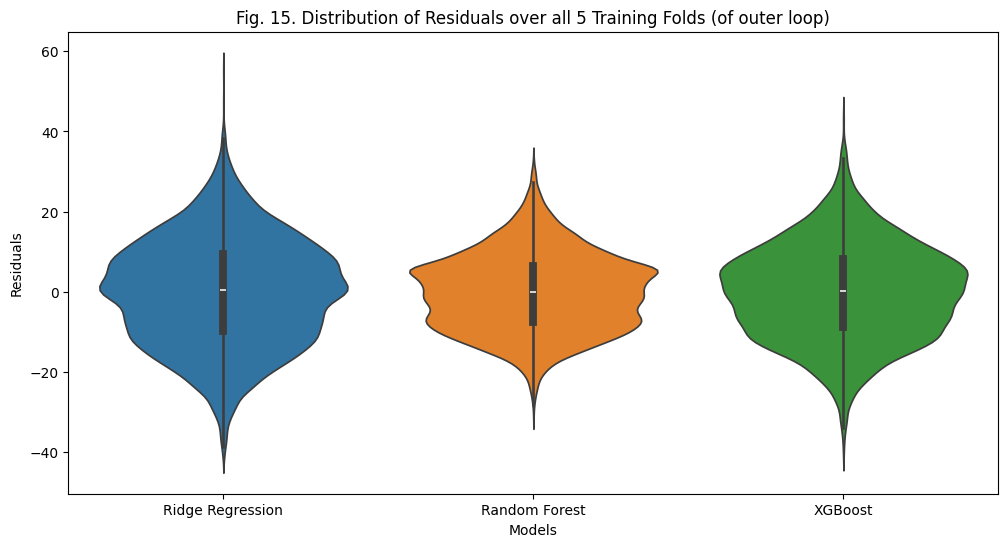

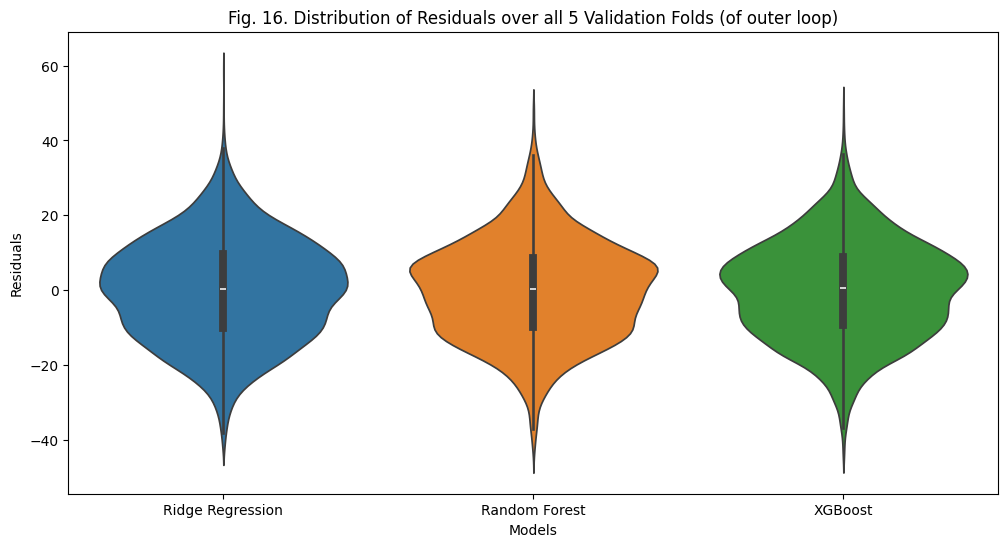

In [16]:
# Create violin plots 
i = 0 # counter for figure
for residuals, set in zip([all_residuals_train, all_residuals_val], ['Training', 'Validation']):
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=residuals)
    plt.xlabel('Models')
    plt.ylabel('Residuals')
    plt.title(f'Fig. {15+i}. Distribution of Residuals over all 5 {set} Folds (of outer loop)')
    plt.xticks(range(len(residuals)), model_names)  # Set x-axis ticks and labels
    i += 1

**Feature Importance:**

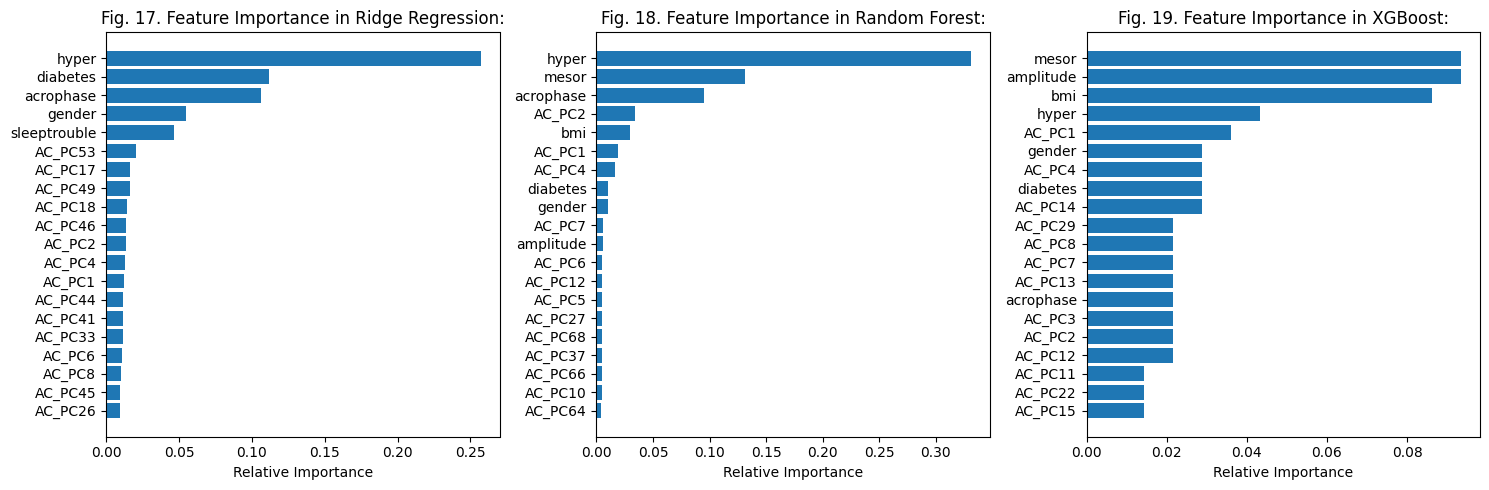

In [17]:
# Feature Importance in Ridge Regression (20 most important features)
# Note: I used the best model of fold 5 of the outter loop for this analysis

importance_RR = np.abs(best_models[4].coef_)
importance_RR = importance_RR/np.sum(importance_RR)

# Feature Importance in Random Forest (20 most important features)
importance_RF = best_models[9].feature_importances_

# Feature Importance in XGBoost
importance_xgboost = best_models[14].get_booster().get_score(importance_type='weight')
importance_xgboost = np.fromiter(importance_xgboost.values(), dtype=float) # convert it to numpy array
importance_xgboost = importance_xgboost/np.sum(importance_xgboost)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot feature importance for both algorithms
for i, importance in enumerate([importance_RR, importance_RF, importance_xgboost]):
    # Get the indices that would sort the array in descending order
    sorted_indices = np.argsort(importance)[::-1][:20]
    
    # Plotting the feature importances
    axes[i].barh(range(20), importance[sorted_indices][::-1])
    axes[i].set_yticks(range(20), np.array(X_train_final.columns)[sorted_indices][::-1])
    axes[i].set_xlabel('Relative Importance')
    axes[i].set_title(f'Fig. {17+i}. Feature Importance in {model_names[i]}:')

plt.tight_layout()

### Model Training and Evaluation
The nested cross-validation serves not just for hyperparameter tuning but also as an evaluation method to compare the three algorithms. The best hyperparameter settings from every inner loop were trained and evaluated on the current outer loop, repeating this process across all 5 folds. This yielded 5 distinct evaluation scores, each associated with the best hyperparameter settings. Averaging these scores over the outer loops provided a comprehensive performance estimate with standard deviation, offering valuable insights into model stability and resilience to diverse datasets. Linear regression with ridge regularization exhibited minimal variation, particularly in RMSE, despite its lowest overall performance.

Nested cross-validation delivers a robust estimate of the generalization error, avoiding selection bias. This approach ensures that the model is trained and tested across all available data, avoiding overfitting to a specific dataset. However, it comes at the cost of not yielding a concrete model with hyperparameters, as these may vary between iterations. Furthermore, the computational expense is high since every model must be fit many times.

Considering the outcomes of the outer evaluation loop, XGBoost slightly outperformed the other algorithms. Its advantages, including relatively low computational costs, interpretability, and utilization of various features (including accelerometer features) with similar considerable weights, led to the decision to use XGBoost as the final model. Fitting the model to the entire training dataset and evaluating it on the untouched test set yielded nearly identical scores compared to the averaged results on the 5 validation sets (Tab. 13), indicating a consistent and reliable estimate of the model's generalization error. The slightly better scores on the training set, coupled with the marginally superior correlation of true and predicted age (see Fig. 20, 21), indicate a well-fitted model without clear signs of overfitting.

In [18]:
# Determine the best algorithm and select best hyperparameters based on 5-fold CV
gcv_model_select = GridSearchCV(estimator=models[2], param_grid=param_grids[2], scoring='neg_mean_squared_error', n_jobs=-1, cv=5, refit=True)
gcv_model_select.fit(X_train_final, y_train)
print('Tab. 13.')
print(f'\nAverage MSE for XGBoost Regression over 5 folds: {np.sqrt(-1 * gcv_model_select.best_score_):.2f}')
print(f'Best parameters for XGBoost Regression: {gcv_model_select.best_params_}')

# Evaluate the best model with the found settings (already trained on the whole training set using refit=True)
y_pred_train = gcv_model_select.best_estimator_.predict(X_train_final)
rmse_train, mae_train = calculate_metrics(y_train, y_pred_train)

y_pred_test = gcv_model_select.best_estimator_.predict(X_test_final)
rmse_test, mae_test = calculate_metrics(y_test, y_pred_test)

print(f'\nTraining MSE: {rmse_train:.2f}')
print(f'Training MAE: {mae_train:.2f}')
print(f'\nTest MSE: {rmse_test:.2f}')
print(f'Test MAE: {mae_test:.2f}')

Tab. 13.

Average MSE for XGBoost Regression over 5 folds: 13.09
Best parameters for XGBoost Regression: {'max_depth': 3, 'n_estimators': 20}

Training MSE: 12.05
Training MAE: 9.75

Test MSE: 13.11
Test MAE: 10.60


In [19]:
# Define functions to calculate residuals and plot scatterplot with true vs. predicted values
def plot_true_vs_predicted(y_true, y_pred, axis, fig=1, residuals=False, label='test', alpha=0.5):
    """
    Plot a scatter plot comparing true vs. predicted values and optionally return residuals.

    Parameters:
    - y_true (array-like): True values.
    - y_pred (array-like): Predicted values.
    - axis: Axes to plot on.
    - fig (int): Figure number.
    - residuals (bool): If True, calculate and display residuals statistics.
    - label (str): Label for the plot.
    - alpha (float): Alpha value for transparency in scatter plot.

    Returns:
    - If residuals is True, returns a tuple of residuals DataFrame and its summary statistics.
    """
    
    # Compare data and predicted values in a scatter plot
    sns.regplot(x=y_true, y=y_pred, scatter_kws={'s': 50, 'alpha': alpha}, line_kws={'color': 'orange'}, ax=axis)
    axis.set_xlabel('Actual Age', fontsize=15)
    axis.set_ylabel('Predicted Age', fontsize=15)
    axis.set_title(f'Fig. {fig}. True vs. Predicted ({label})', fontsize=18)
    
    # Calculate and display correlation coefficient
    spearman_corr, _ = spearmanr(y_true, y_pred)
    axis.annotate(f'r = {spearman_corr:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=15)

    # Calculate residuals statistics for the predictions
    if residuals == True:
        residuals = pd.DataFrame(y_true - y_pred)
        return residuals, residuals.describe().set_axis([label], axis=1)

def residual_analysis(y_true, residuals, axis, fig=1, label='test', alpha=0.5):
    """
    Plot residuals as a function of true age.

    Parameters:
    - y_true (array-like): True values.
    - residuals (array-like): Residuals.
    - axis: Axes to plot on.
    - fig (int): Figure number.
    - label (str): Label for the plot.
    - alpha (float): Alpha value for transparency in scatter plot.
    """
    
    # Plot residuals as a function of true age
    sns.regplot(x=y_true, y=residuals, scatter_kws={'s': 50, 'alpha': alpha}, line_kws={'color': 'orange'}, ax=axis)
    axis.axhline(y=0, color='r', linestyle='--')  
    axis.set_xlabel('Actual Age', fontsize=15)
    axis.set_ylabel('Residuals', fontsize=15)
    axis.set_title(f'Fig. {fig}. Residuals as a Function of Actual Age ({label})', fontsize=18)

Tab. 14. Distributions of errors made by XGBoost:


,Training,Test
count,5229.000000,1308.000000
mean,-0.002474,0.461428
std,12.046211,13.104182
min,-41.247055,-40.706398
25%,-8.789845,-9.110125
50%,0.135174,0.690542
75%,8.041069,9.328127
max,44.507050,42.064690


([<matplotlib.axis.XTick at 0x7fd9e882fa00>,
 [Text(0, 0, 'Training'), Text(1, 0, 'Test')])

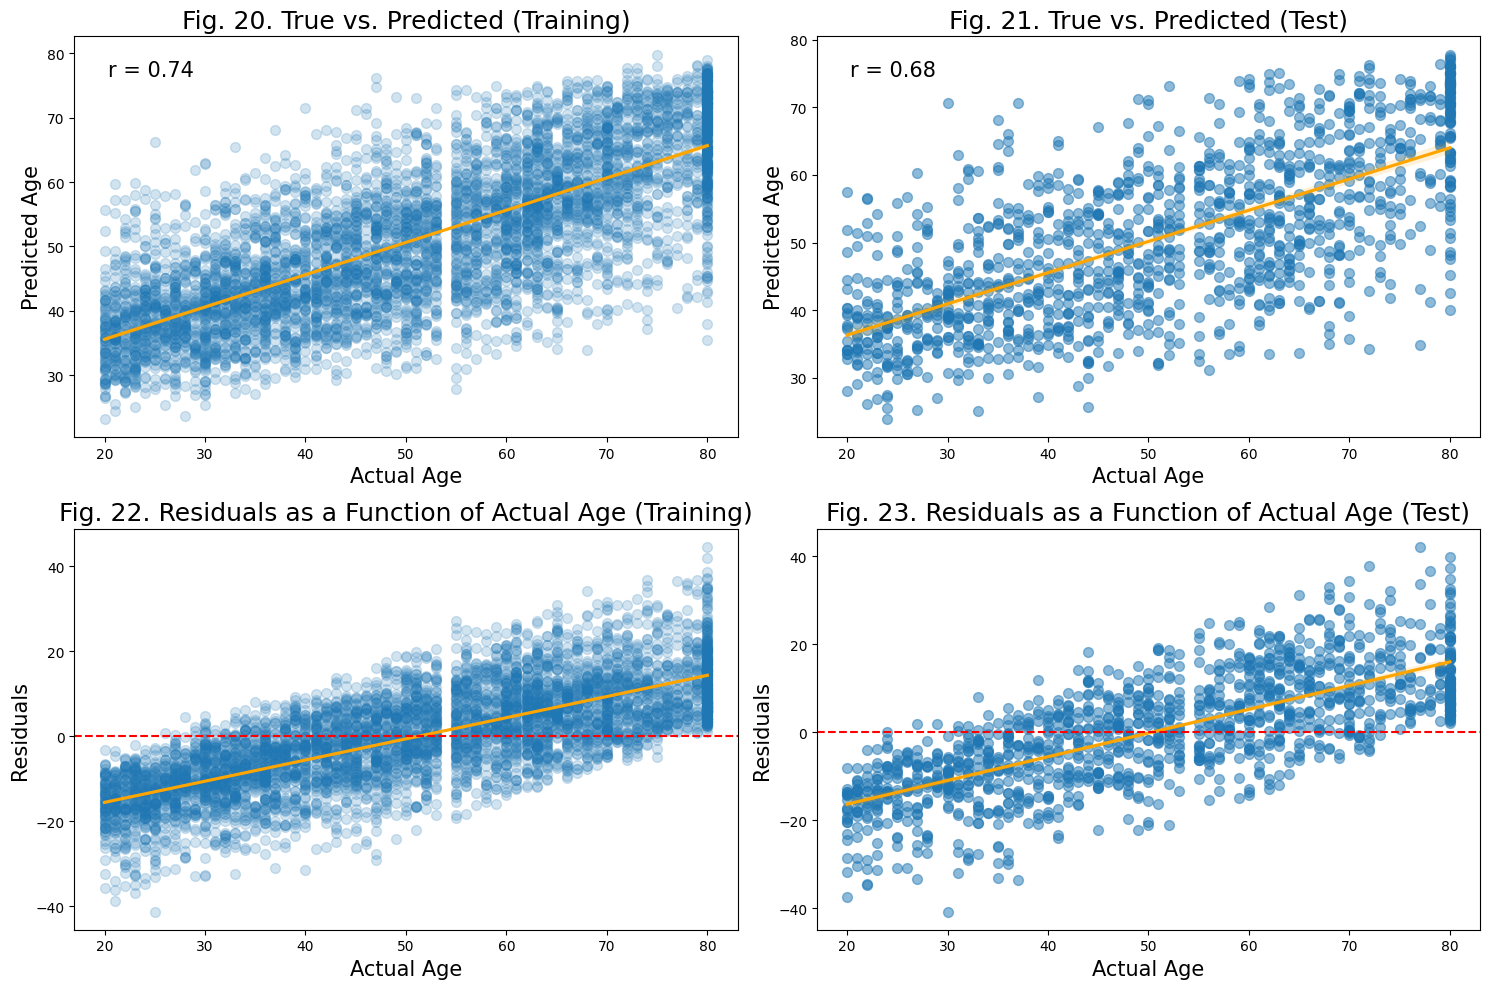

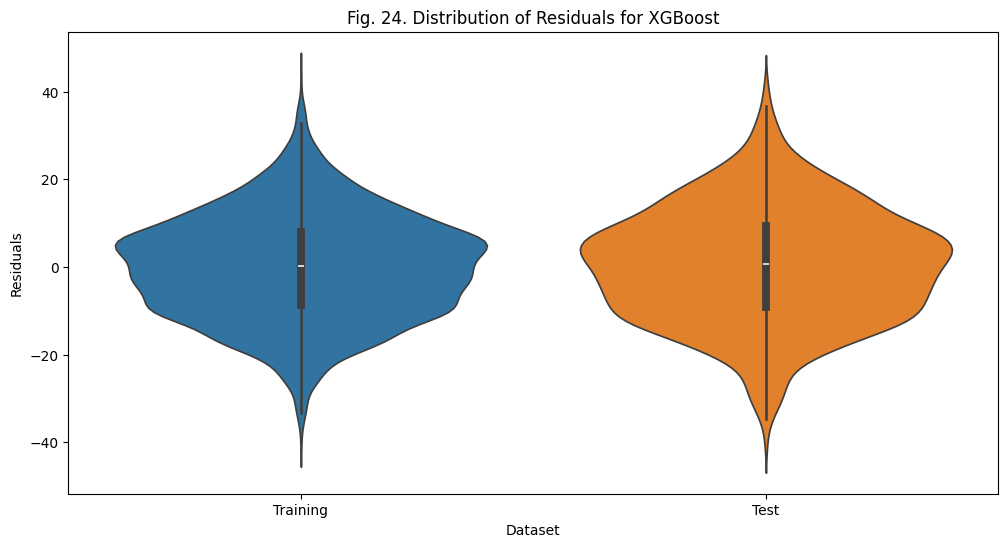

In [20]:
# Compare data and predicted values in a scatter plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

residuals_train, train_summary = plot_true_vs_predicted(y_train, y_pred_train, fig=20, residuals=True, label='Training', axis=axes[0,0], alpha=0.2)
residuals_test, test_summary = plot_true_vs_predicted(y_test, y_pred_test, fig=21, residuals=True, axis=axes[0,1], label='Test')

print('Tab. 14. Distributions of errors made by XGBoost:')
residuals_summary = pd.concat([train_summary, test_summary], axis = 1)
display(residuals_summary)

# Plot residuals as a function of true age
residual_analysis(y_train, residuals_train, axis=axes[1,0], fig=22, label='Training', alpha=0.2)
residual_analysis(y_test, residuals_test, axis=axes[1,1], fig=23, label='Test')
plt.tight_layout()

# Create violin plots 
residuals = [residuals_train['age'].values.tolist(), residuals_test['age'].values.tolist()]

fig = plt.figure(figsize=(12, 6))
sns.violinplot(data=residuals)
plt.xlabel('Dataset')
plt.ylabel('Residuals')
plt.title('Fig. 24. Distribution of Residuals for XGBoost')
plt.xticks(range(2), ['Training', 'Test'])  # Set x-axis ticks and labels

## 6. Making Predictions on My Own Data 
1. Plot my accelerometer data.
2. Apply my trained model to make predictions on my own data. 

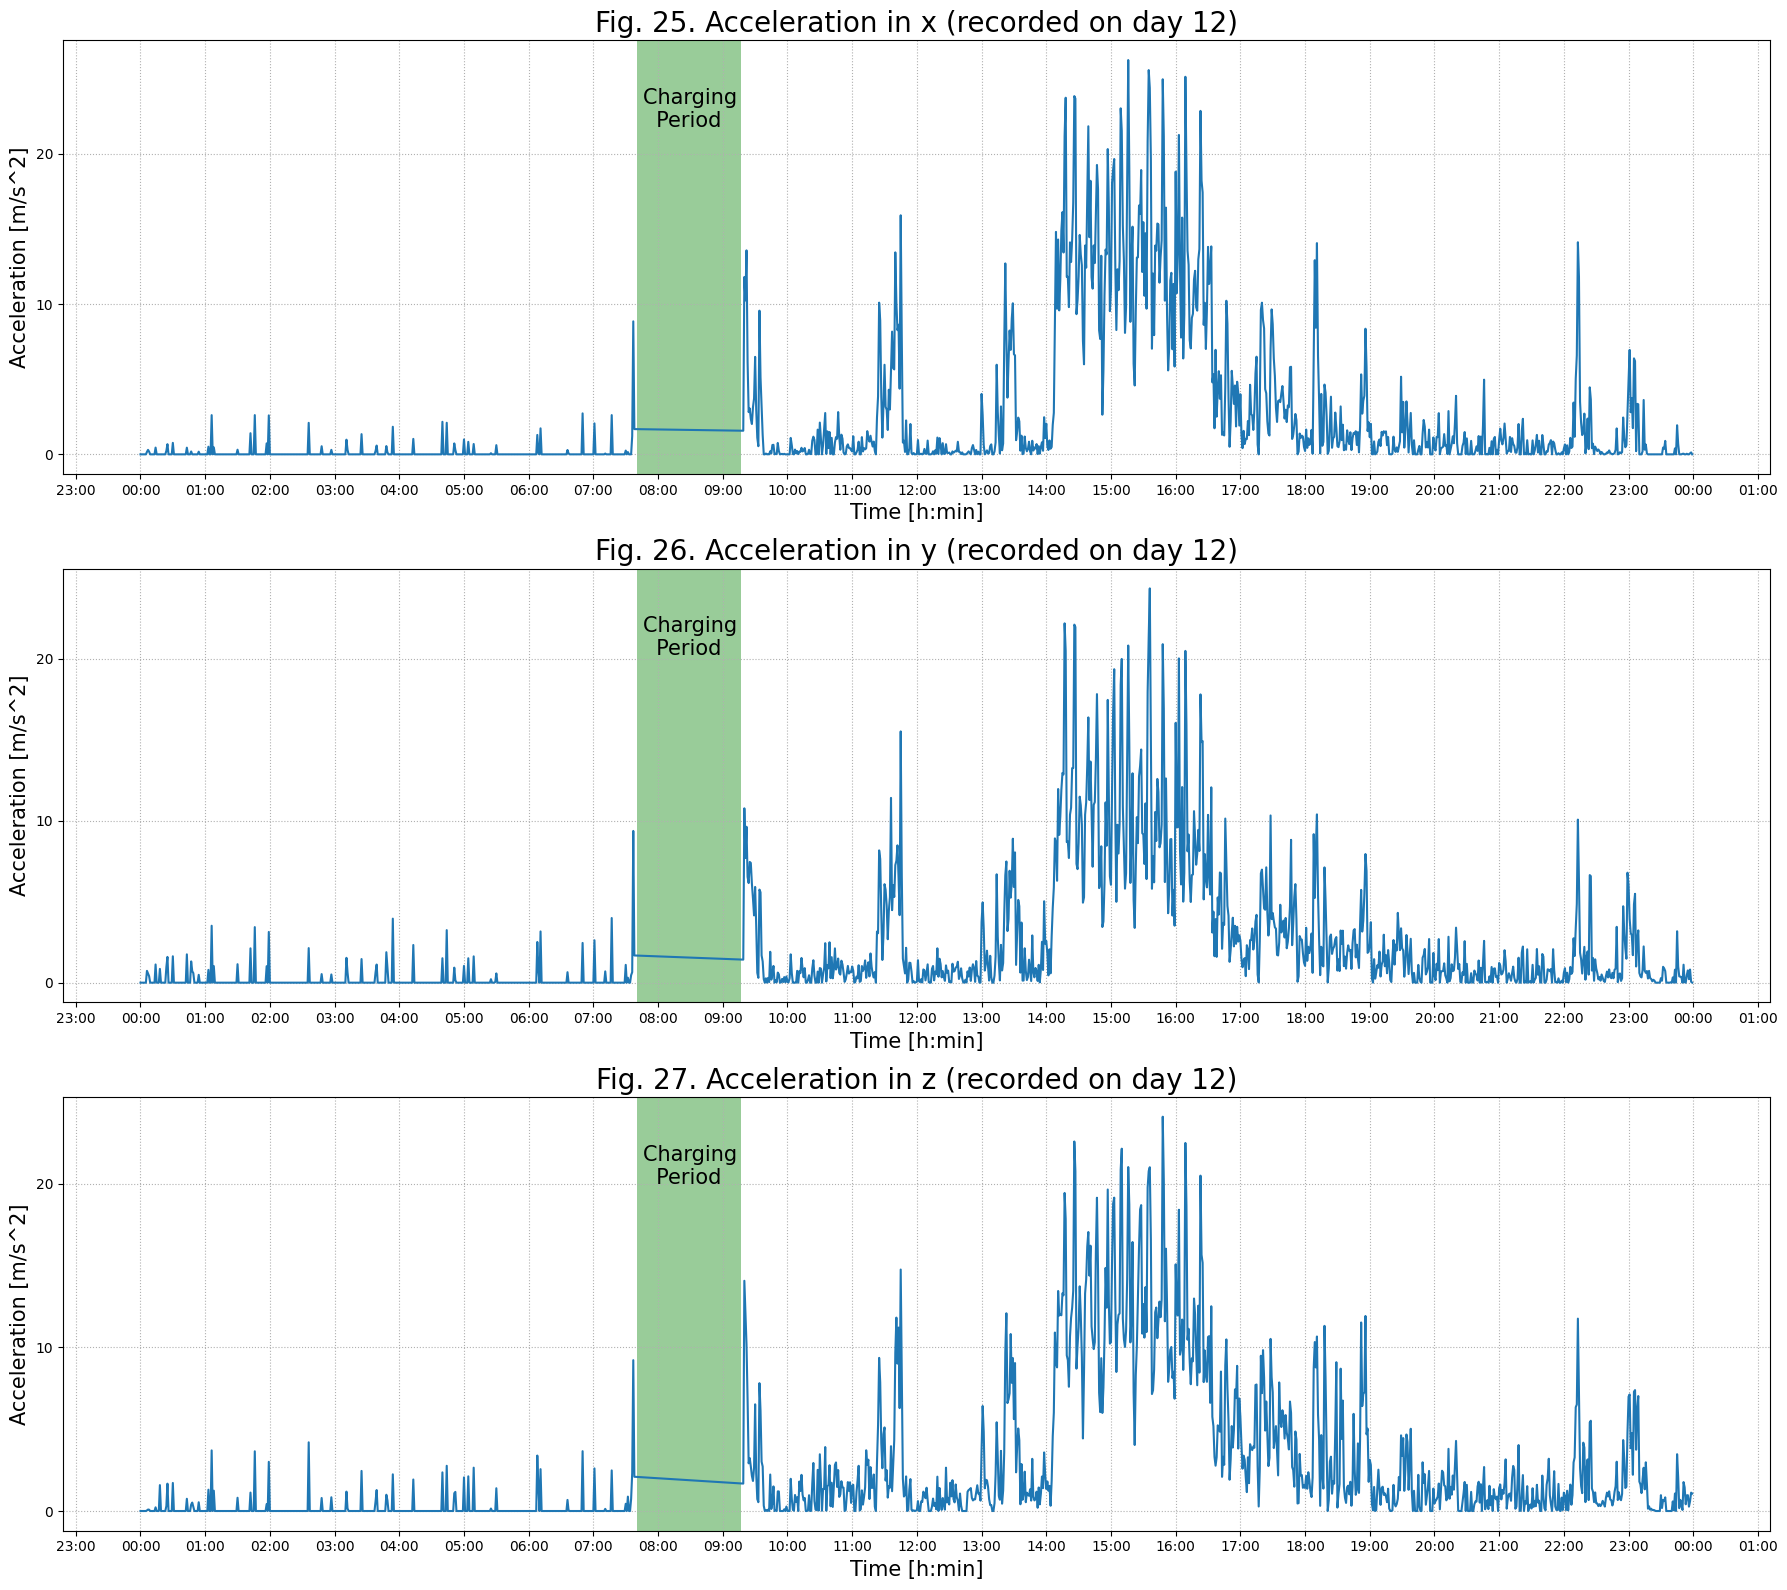

In [28]:
# Plot accelerometer data

# Importing matplotlib and use it to plot the accelerometer data of 1 day over time. 
# Create one plot for each of the three axis x, y, z. 

# Prepare data
myacc_plot = myacc.loc[myacc['day'] == 12][['time', 'Axis1', 'Axis2', 'Axis3']]
myacc_plot = myacc_plot.rename(columns = {'Axis1': 'x', 'Axis2': 'y', 'Axis3': 'z'})

# Prepare parameters for plotting
hours = mdates.HourLocator(interval = 1)
fmt = mdates.DateFormatter('%H:%M') 
fig,axes = plt.subplots(3, 1, figsize = (18,16))

for i,dimension in enumerate(['x','y','z']):
    axes[i].xaxis.set_major_locator(hours)
    axes[i].xaxis.set_major_formatter(fmt)
    axes[i].set_yticks(np.arange(-70,70,10))
    axes[i].plot(myacc_plot["time"], myacc_plot[dimension]*9.81/4096)
    axes[i].axvspan(xmin='2023-10-21 07:40:00', xmax='2023-10-21 09:17:00', facecolor='g', alpha=0.4)
    axes[i].annotate('Charging \n  Period', xy=(0.34, 0.8), xycoords='axes fraction', fontsize=15)
    axes[i].set_title(f'Fig. {25+i}. Acceleration in {dimension} (recorded on day 12)', fontsize=20) 
    axes[i].set_xlabel('Time [h:min]', fontsize=15)
    axes[i].set_ylabel('Acceleration [m/s^2]', fontsize=15)
    axes[i].grid(linestyle=':')

plt.tight_layout()

**Preprocess my data the same way like the training set:**

In [22]:
# Add personal data
mydf_final[['gender', 'bmi', 'hyper', 'diabetes', 'sleephours', 'sleeptrouble']] = [0, 23.2, 0, 0, 8, 0]
mydf_final[['h57', 'h85']] = np.nan  # missing data

# Make sure that all values are numeric (instead of categorical dtype)
mydf_final = mydf_final.apply(pd.to_numeric) 

# Impute missing values ('h57', 'h85') with Forward Fill
mydf_final = mydf_final.fillna(method='ffill', axis=1)

# Drop certain features
mydf_final = mydf_final[X_train.columns]

# Standardization and dimensionality reductio with PCA of the hourly mean AC columns
hourly_mydf = mydf_final[hourly_columns]   # Extract hourly mean AC columns
hourly_mydf_scaled = scaler.transform(hourly_mydf)  # Standardize the data
pca_mydf = pca.transform(hourly_mydf_scaled)   # Apply PCA
mydf_selected = pca_mydf[:, :n_components_95]  # Select the first 94 principal components
mydf_pc_df = pd.DataFrame(data=mydf_selected, columns=pc_columns)  # Create DataFrame for the selected principal components
mydf_combined = pd.concat([mydf_final[mydf_final.columns[:9]].reset_index(drop=True), mydf_pc_df.reset_index(drop=True)], axis=1)

# No Lasso feature selection for XGBoost

In [23]:
y_pred = gcv_model_select.best_estimator_.predict(mydf_combined)[0]
print('Tab. 15.')
print('   Predicted Age:', int(np.round(y_pred)))
print('   Actual Age: 23')
print('   Error:', int(23 - np.round(y_pred)))

Tab. 15.
   Predicted Age: 35
   Actual Age: 23
   Error: -12


## 7. Discussion of results 
Interpretation of the prediction results. Is the prediction good or poor? Identifying factors that may influence the predictions include:

- **Rhythm Consistency:** Evaluate the consistency of your rhythm. Does it exhibit a stable pattern, or are there significant fluctuations? 
- **Wear Time:** Reflect on your study participation. Did you experience substantial periods of missing wear time, potentially impacting the overall data quality?
- **Data Quality:** Check if your data for an excessive number of zero counts, particularly during non-sleep/rest hours. Why? 
- **Cosinor Fit:** Assess the appropriateness of a cosinor model for your data. Does it effectively capture the underlying patterns, or are there discrepancies that suggest a poor fit?

The model's predicted age for me is 35 (Tab. 15). Considering my real age is 23, the absolute error of the prediction is 12. This discrepancy seems reasonable given the test RMSE of 13.11 and MAE of 10.6 for the model. Examining the plotted residuals against the actual age in Figure 23 for an unseen test set reveals a consistent uncertainty in predictions across different age groups. This is evident in the consistent thickness of the residual band. However, the model tends to overpredict the youngest individuals of 20 years by about 15 years on average, while underpredicting the oldest individuals of 80 years by a similar margin. Therefore, a 12-year overprediction is reasonable, especially when considering that the average overprediction for individuals in my age group is around 15 years.

The model generally works best for individuals around 50 years old, with no noticeable tendency to under or overpredict. Reviewing the true vs. predicted age values in Figure 21 reinforces this observation, as the fitted trendline aligns closely with the (50,50) coordinate, indicating optimal predictions for individuals aged 50.

Regarding the quality of my data, it's notable that some days exhibit straight-line artifacts for all three sensors, lasting approximately 1 hour. This is attributed to missing values during watch charging. Imputing missing values using Forward Fill, however,  should not significantly impact predictions, given we have only 2 missing mean hourly AC values with no data in that full hour. Examining the 6 days of accelerometer data used for prediction revealed no noticeable anomalies, such as an excessive number of zero counts during non-sleep/rest hours. The daily activity patterns varied, with consistent wake and sleep times around 7:45 and 23:00, respectively. On the day displayed in Fig. 25-27, a Padel game from 14:00-16:00 explained rapid fluctuations, while a strength training session typically led to a peak at 19:30.

The fit of the cosinor model, while not perfect, is acceptable (see Fig. 28 below). The low R-squared indicates that the model explains only a small portion of the variability in the data, comparable to the experiments in exercise 3. Achieving better fits seems challenging due to daily fluctuations disrupting the pattern, as activities like a party could cause significant disturbances. Despite this, the fitted model captures the overall rhythmicity, and attempts to improve by adding more components result only in marginal enhancements.

Fig. 28.

Cosinor Fit R-squared: 0.11


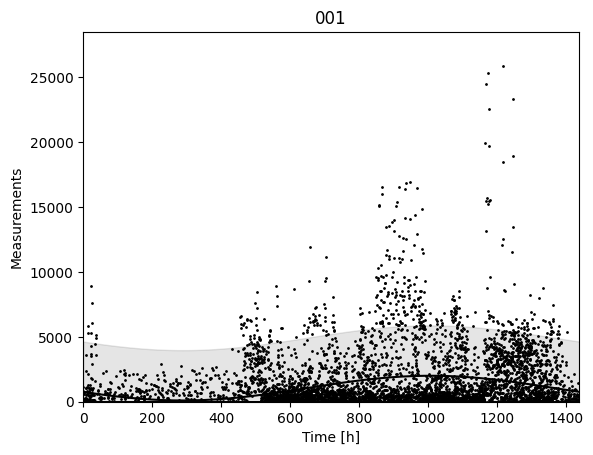

In [26]:
# Examine the Cosinor Fit
print('Fig. 28.\n')
print(f'Cosinor Fit R-squared: {cos_results["R2"][0]:.2f}')
cos_results = cosinor.fit_group(cosdf, n_components=[1], period=1440, plot=True, plot_phase=False)  # we have data on a minute basis (24h -> 1440 minutes)

# Ignore the specific warning
warnings.filterwarnings("ignore", message="color is redundantly defined", category=UserWarning)

In [25]:
# Cosinor Models with >1 components
# Get the best fitting periods with criterium 'R2'
cos_results = cosinor.fit_group(cosdf, n_components=[1,2,3], period=1440, plot=False, plot_phase=False)  # we have data on a minute basis (24h -> 1440 minutes)
df_best_fits = cosinor.get_best_fits(cos_results, n_components = [1,2,3], criterium='R2', reverse = False)
df_best_fits[['n_components', 'R2']]

,n_components,R2
0,1.0,0.106019
1,2.0,0.117609
2,3.0,0.120508
